In [1]:
import numpy as np
import numpy.linalg as la

class Wheel:
    def __init__(self, pos, vel, force_z, mass, radius, width):
        # parameters
        self.pos = pos
        self.radius = radius
        
        # derived quantities
        self.vel = vel # ground contact velocity of wheel
        self.force_z = force_z # weight of vehicle carried by wheel
        Ix = Iz = (1/12)*mass*(3*radius**2 + width)
        Iy = (1/2)*mass*radius**2
        self.inertia = np.diag([Ix,Iy,Iz])
        
        # inputs
        self.drive_torque = 0
        self.steer_angle = 0
        
        # states
        self.omega = 0
    
    def sideslip(self):
        return self.steer_angle - np.arctan2(self.vel[1], self.vel[0])
    
    def slips(self):
        # angle between rotational equivalent velocity
        # and ground contact point velocity
        sideslip = self.sideslip()
        
        speed_rot = self.omega * self.radius
        speed_w = la.norm(self.vel[:2])
        
        speed_rot_l = speed_rot*np.cos(sideslip) # rotation speed in travel direction
        speed_rot_s = speed_rot*np.sin(sideslip)
        
        eps = 1e-5 # avoid division with zero
        if speed_rot_l <= speed_w:
            slip_l = (speed_rot_l - speed_w)/(speed_w + eps)
            slip_s = speed_rot_s/(speed_w+eps)
        else:
            slip_l = (speed_rot_l - speed_w)/(speed_rot_l + eps)
            slip_s = speed_rot_s/(speed_rot_l+eps)
        
        return slip_l, slip_s
    
    def friction_coeffs(self, slip_l, slip_s):
        slip_res = la.norm([slip_l, slip_s])
        
        c1, c2, c3 = 1.28, 23.99, 0.52
        mu_res = c1*(1 - np.exp(-c2*slip_res)) - c3*slip_res
        
        thread_attenuation = 1.0
        mu_l = mu_res * slip_l/slip_res
        mu_s = mu_res * slip_s/slip_res * thread_attenuation
        
        return slip_l, slip_s
    
    def friction_forces(self):
        slip_l, slip_s = self.slips()
        mu_l, mu_s = self.friction_coeffs(slip_l, slip_s)
        
        force_wl = mu_l * self.force_z
        force_ws = mu_s * self.force_z
        
        # force_wl is in direction of vel_w[0]
        # force_ws is in direction of vel_w[1]
        # rotate them to align with wheel rotation
        sideslip = self.sideslip()
        force_l = force_wl*np.cos(sideslip) + force_ws*np.sin(sideslip)
        force_s = -force_wl*np.sin(sideslip) + force_ws*np.cos(sideslip)
        
        return force_l, force_s
    
    def states_dot(self):
        force_l, force_s = self.friction_forces()
        return (self.drive_torque - self.radius*force_l)/self.inertia[1,1]
    
    def states(self):
        return self.omega
    

    
class Vehicle:
    def __init__(self, mass, wheels):
        self.mass = mass
        self.pos = np.array([0,0,0])
        self.vel = np.array([0,0,0])
        self.yaw = 0
        self.yawrate = 0
        self.wheels = wheels
        
        
    def states(self):
        return np.hstack([self.pos, self.vel, self.yaw, self.yawrate])
    
    def states_dot(self):
        
        total_force_cg = np.array([0,0,0])
        total_torque_cg = np.array([0,0,0])
        
        for wheel in wheels:
            force_l, force_s = wheel.friction_forces()
            sideslip = wheel.sideslip()
            angle = -sideslip + wheel.steer_angle
            
            force_cg = np.array([
                force_l*np.cos(angle) + force_s*np.sin(angle),
                -force_l*np.sin(angle) + force_s*np.cos(angle),
                0
            ])
            torque_cg = np.cross(wheel.pos, force_cg)
            
            total_force_cg = total_force_cg + force_cg
            total_torque_cg = total_torque_cg + torque_cg
            
            
        
        accel = total_force_cg
        yawaccel = total_torque_cg[2]
        
        return np.hstack([self.vel, accel, self.yawrate, yawaccel])

In [2]:
g = 9.81
vehicle_mass = 5000

length_front = 1.0
length_rear = 2.5
width_front = 2.0
width_rear = width_front

wheel_mass = 200 # kg
wheel_radius = 0.75 # meters
wheel_width = 0.4 # meters

pos_wfl = np.array([length_front, width_front/2, 0])
pos_wrl = np.array([length_rear, width_rear/2, 0])
pos_wrr = np.array([length_rear, -width_rear/2, 0])
pos_wfr = np.array([length_front, -width_front/2, 0])

In [3]:
# stationary load transfer
bf = width_front
br = width_rear
lf = length_front
lr = length_rear

A = np.array([
    [1, 1, 1, 1],
    [-bf, -br, br, bf],
    [lf, -lr, -lr, lf],
    [lf+lr, 0, 0, lf+lr],
    [0, -lf-lr, -lf-lr, 0]])
b = np.array([vehicle_mass*g, 0, 0])

print(f"Rank(A)={la.matrix_rank(A)}")

# TODO: rank is too small, need to figure this out
# meanwhile do fz=Mg/4
fz = np.ones((4,))*vehicle_mass*g/4
force_zfl = fz[0]

Rank(A)=3


In [31]:

class ImprovedEulersMethod:
    def __init__(self, f):
        self.f = f # x' = f(x,t)

    def step(self,x,t,h):
        k1 = self.f(x,t)
        k2 = self.f(x+h*k1, t+h)

        return x + h/2*(k1 + k2)
    
class EulersMethod:
    def __init__(self, f):
        self.f = f # x' = f(x,t)

    def step(self,x,t,h):
        k1 = self.f(x,t)

        return x + h*k1
    
    


<IPython.core.display.Javascript object>


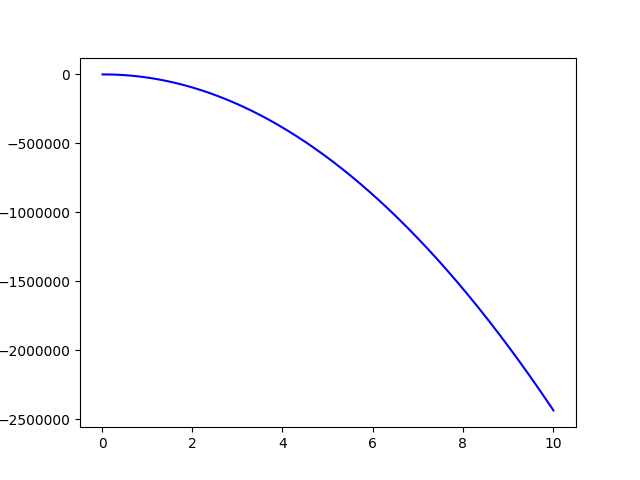

/home/cale/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars
/home/cale/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


In [34]:
from scipy.integrate import ode
%matplotlib notebook
import matplotlib.pyplot as plt
import time

plt.rcParams["animation.html"] = "html5"

vel_w = np.array([0,0,0])

wheel_fl = Wheel(pos_wfl, vel_w, fz[0], wheel_mass, wheel_radius, wheel_width)
wheel_rl = Wheel(pos_wrl, vel_w, fz[1], wheel_mass, wheel_radius, wheel_width)
wheel_rr = Wheel(pos_wrr, vel_w, fz[2], wheel_mass, wheel_radius, wheel_width)
wheel_fr = Wheel(pos_wfr, vel_w, fz[3], wheel_mass, wheel_radius, wheel_width)

wheels = [wheel_fl, wheel_rl, wheel_rr, wheel_fr]
vehicle = Vehicle(vehicle_mass, wheels)


def states(vehicle):
    cg_states = vehicle.states()
    wheel_states = np.array([wheel.states() for wheel in vehicle.wheels]).flatten()
    
    return np.hstack([cg_states, wheel_states])

def states_dot(vehicle):
    cg_states_dot = vehicle.states_dot()
    wheel_states_dot = np.array([wheel.states_dot() for wheel in vehicle.wheels]).flatten()
    
    return np.hstack([cg_states_dot, wheel_states_dot])

def states_set(vehicle, x):
    vehicle.pos = x[:3]
    vehicle.vel = x[3:6]
    vehicle.yaw = x[6]
    vehicle.yawrate = x[7]
    
    wheel_states = x[8:] # assumes one state per wheel
    assert len(x[8:]) == 4
    for wheel, omega in zip(wheels, wheel_states):
        wheel.omega = omega
    

def f(t, y):
    """
    State-space model
    x = [
    vehicle_states,
    *wheel_states,
    ]
    """
    return states_dot(vehicle)






fig = plt.figure()
ax = fig.add_subplot(1,1,1)
fig.show()

ts, xs, us = [], [], []

solver = ImprovedEulersMethod(f)

t, dt, tstop = 0, 0.01, 10
while t < tstop:
    # Measurements
    x = states(vehicle)
    vehicle_yawrate = vehicle.yawrate
    
    # Control
    u = np.array([
        10,
        0,
        10,
        0,
        10,
        0,
        10,
        0
    ])
    nu = u.size
    assert nu == 8, "sanity check failed"
    
    for wheel, i in zip(wheels, range(0,nu,2)):
        wheel.drive_torque = u[i]
        wheel.steer_angle = u[i+1]
    
    # Setup simulation step
    vehicle_rotation = np.array([0,0,vehicle_yawrate])
    for wheel in wheels:
        vel_rot = np.cross(vehicle_rotation, wheel.pos)
        wheel.vel = vehicle.vel + vel_rot

    
    # Step forward
    x = solver.step(x, t, dt)
    t += dt
    
    states_set(vehicle, x)
    
    
    # Store for plotting
    ts.append(t)
    xs.append(x)
    us.append(u)
    

ts = np.asarray(ts)
xs = np.asarray(xs)
us = np.asarray(us)

    
ax.plot(ts, xs[:,0], color='b')
fig.canvas.draw()
   
    
    

In [24]:
np.array(ts).shape

(1001,)

<IPython.core.display.Javascript object>


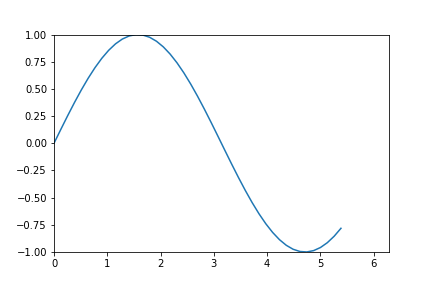

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

plt.rcParams["animation.html"] = "jshtml"

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0, 2*np.pi, -1, 1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(
    fig, animate, frames=len(t))


In [ ]:
import time
import psutil
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams["animation.html"] = "html5"

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
fig.show()

In [35]:
i = 0
x,y = [], []

while i < 100:
    x.append(i)
    y.append(psutil.cpu_percent())
    
    ax.plot(x,y, color='b')
    
    fig.canvas.draw()
    
    ax.set_xlim([i-50, i+50])
    
    time.sleep(0.1)
    i += 1

In [26]:
psutil.cpu_percent()

26.5